# COVID-19 effect on Unemployment : part 4 - Industry
### by Martin Dionne

I analysed the following paper on the impact of COVID-19 on different industries.

## The CoRisk-Index: A data-mining approach to identify industry-specific risk assessments related to COVID-19 in real-time
#### 27th April 2020 - Fabian Stephany et al.

>The study presented here investigates a potential data source that could provide an empirical basis to identify industry-specific economic risks related to COVID-19 and to inform models on the economic effects of the current crisis. We examine company risk reports (10-K reports) filed to the U.S. Securities and Exchange Commission (SEC) and introduce a data-mining approach to measure firms’ risk assessments.
>
>...
>
>The empirical information provided could help to inform macro-economic models on the effects of the corona-crisis and, thus, help to inform policymakers to better target current economic support programmes to industries that report most severe risks at the current phase of the crisis.
>
>...
>
>The robustness of the results needs to be checked in more detail. In particular, we will compare historical and unemployment data with risk measures (text negativity) extracted from 10-K reports to investigate the correlation between risk reports and overall economic trends.

TLDR; They use mentions of COVID-19 in risk assesments reports to predicts which industries should receive economic support.

My goal is to validate the hypothesis and measure if it translate to the Canadian economy.

Source: https://arxiv.org/abs/2003.12432

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#import datetime as dt

In [34]:
# unemployment by industry (Canada) 
#https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410002201

df = pd.read_csv('1410002201_databaseLoadingData_ind2019_pt.csv')
#df

In [35]:
# function to get a year of data for specific industry
def query_year(df, geo='Canada', sex='Both sexes', age='15 years and over', 
               labor='Unemployment rate', naics='Total, all industries', year='2020'):

    df2 = df
    df2['DATE'] = pd.to_datetime(df2.REF_DATE)
    df2.DATE = df2.DATE.dt.strftime("%m")
    df2 = df2.loc[((df2.GEO == geo) & 
                   (df2.Sex == sex) &
                   (df2['Age group'] == age) &
                   (df2['Labour force characteristics'] == labor) &
                   (df2['North American Industry Classification System (NAICS)'] == naics) &
                   (df2.REF_DATE.str.contains(year))
                  )]
    return df2

In [52]:
unemp_2020 = query_year(df, year='2020')
unemp_2019 = query_year(df, year='2019')

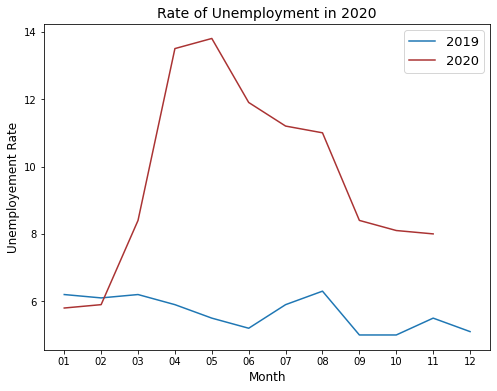

In [7]:
fig, ax = plt.subplots(nrows=1, sharey=True, figsize = (8,6))
ax.plot(unemp_2019.DATE, unemp_2019.VALUE, label = '2019')
ax.plot(unemp_2020.DATE, unemp_2020.VALUE, label = '2020', color ='#aa3333')
plt.title('Rate of Unemployment in 2020', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Unemployement Rate', fontsize = 12)
plt.legend(fontsize = 13, loc = 'upper right')
plt.show()

 We already demonstrate the link between COVID-19 and unemployment but what is the impact on different industries?

In [38]:
from scipy import stats
# assuming a normal distribution 
# if p < 0.05 the null hypothesis is rejected (unemployement 2020 != 2019 )
stats.ttest_ind(unemp_2020.VALUE, unemp_2019.VALUE) 
# p << 0.05 so it is significant

Ttest_indResult(statistic=4.84600290895813, pvalue=8.629175354319328e-05)

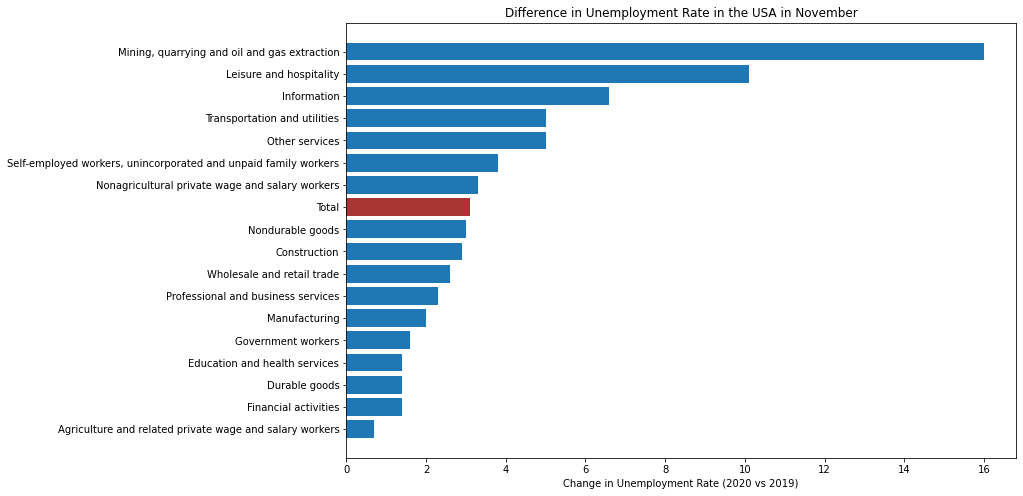

In [64]:
#https://www.bls.gov/web/empsit/cpseea31.htm
#https://www.bls.gov/news.release/empsit.t14.htm

us = pd.read_csv('bls-unemployment-nov.csv')
us['diff'] = us.URnov2020 - us.URnov2019
us = us.sort_values('diff', ascending=False)
us = us.set_index('Industries')

fig, ax = plt.subplots(figsize = (12,8)) 
ax.barh(us.index, us['diff'], align='center')
ax.invert_yaxis()
ax.set_xlabel('Change in Unemployment Rate (2020 vs 2019)')
ax.set_title('Difference in Unemployment Rate in the USA in November')
highlight = 'Total'
pos = us.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')

A new notes about this graph:

* This data is limited to the month of November but it still give an idea of the long lasting effect of COVID-19 on unemployment. 
* Leisure and hospitality (which include restaurants), is one of most impacted industry. The paper couldn't identify this field because of the nature of the SEC (concern only publicly trated compagnies).
* Keep in mind we measure a relative change we don't know the size of the industry (which can be misleading in the case of Mining industry).

Next step is to try to explain the differences with the paper and compare to Canada.

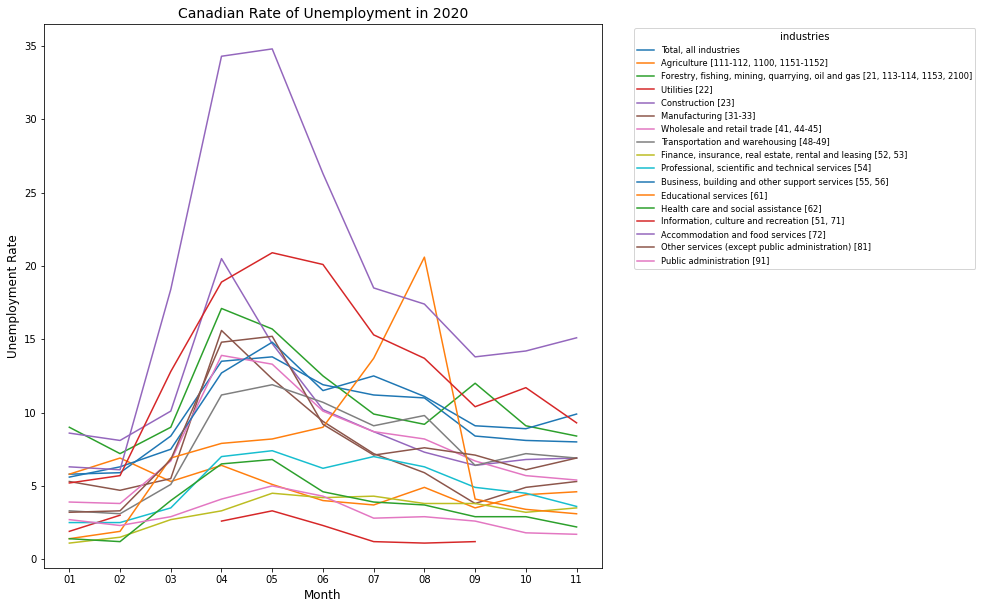

In [69]:
industries = df['North American Industry Classification System (NAICS)'].unique()
fig, ax = plt.subplots(nrows=1, sharey=True, figsize = (10,10))

for i in industries:
    tmp = query_year(df, naics=i, year='2020')
    ax.plot(tmp.DATE, tmp.VALUE, label = i)

plt.title('Canadian Rate of Unemployment in 2020', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Unemployment Rate', fontsize = 12)
#plt.legend(fontsize = 13, loc = 'upper right')
plt.legend(title='industries', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

* In this graph, we can see that Accommodations and Food Services is the most impacted.
* Some industries have their particularities but most follow the same trend.  
* The Orange spike is seasonnal unemployment in Agriculture.

In [55]:
nov2020 = query_month(df, month='2020-11')
nov2019 = query_month(df, month='2019-11')
nov = nov2020.merge(nov2019, on='NAICS')
nov['diff'] = nov['2020-11'] - nov['2019-11']
nov = nov.sort_values('diff', ascending=False)
nov = nov.set_index('NAICS')

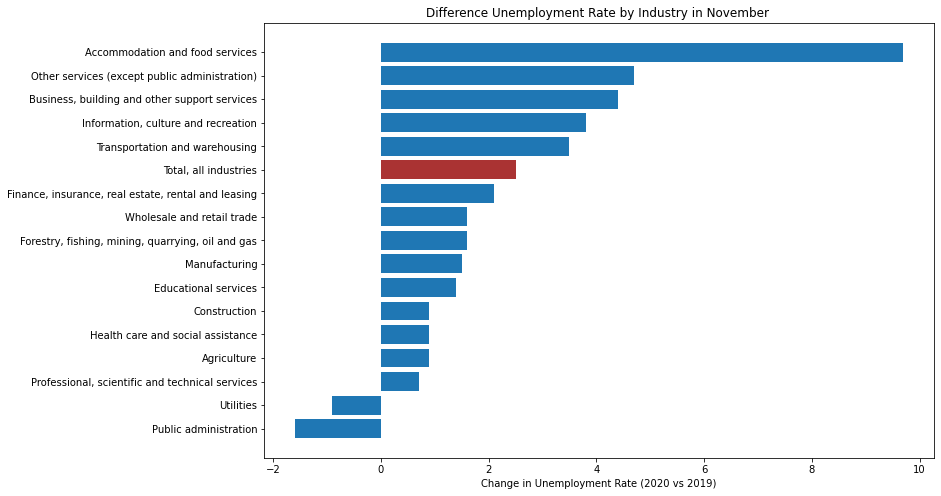

In [65]:
fig, ax = plt.subplots(figsize = (12,8)) 
ax.barh(nov.index, nov['diff'], align='center')
ax.invert_yaxis()
ax.set_xlabel('Change in Unemployment Rate (2020 vs 2019)')
ax.set_title('Difference Unemployment Rate in Canada in November ')
highlight = 'Total, all industries'
pos = nov.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')
plt.show()

In [5]:
# function to get all industries for a specific month
def query_month(df, geo='Canada', sex='Both sexes', age='15 years and over', 
               labor='Unemployment rate', month='2020-11'):

    df2 = df
    df2['DATE'] = pd.to_datetime(df2.REF_DATE)
    df2.DATE = df2.DATE.dt.strftime("%m")
    df2 = df2.loc[((df2.GEO == geo) & 
                   (df2.Sex == sex) &
                   (df2['Age group'] == age) &
                   (df2['Labour force characteristics'] == labor) &
                   (df2.REF_DATE.str.contains(month))
                  )]
    df3 = pd.DataFrame()
    df3['NAICS'] = df2['North American Industry Classification System (NAICS)'].str.replace(r'\[.*\]', '').str.strip()
    df3[month] = df2.VALUE
    df3 = df3.sort_values(month, ascending=False)

    return df3

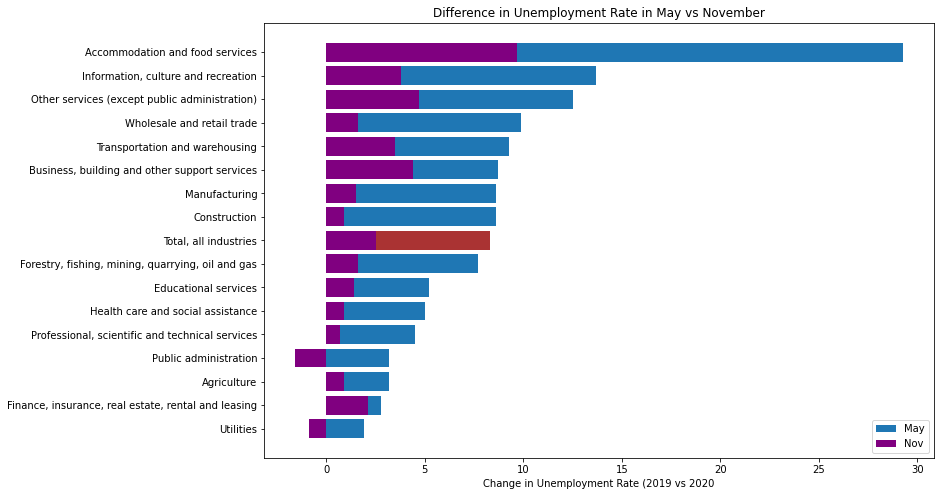

In [61]:
may2020 = query_month(df, month='2020-05')
may2019 = query_month(df, month='2019-05')
may = may2020.merge(may2019, on='NAICS')
may['diff'] = may['2020-05'] - may['2019-05']
may = may.sort_values('diff', ascending=False)
may = may.set_index('NAICS')

fig, ax = plt.subplots(figsize = (12,8)) 
ax.barh(may.index, may['diff'], align='center', label='May')
ax.barh(nov.index, nov['diff'], align='center', label='Nov', color='purple')
ax.invert_yaxis()
ax.set_xlabel('Change in Unemployment Rate (2019 vs 2020')
ax.set_title('Difference in Unemployment Rate in May vs November')
highlight = 'Total, all industries'
pos = may.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')
plt.legend(loc='lower right')
plt.show()

In [66]:
nov2020 = query_month(df, labor='Employment', month='2020-05')
nov2019 = query_month(df, labor='Employment', month='2019-05')
nov = nov2020.merge(nov2019, on='NAICS')
nov['diff'] = nov['2020-05'] - nov['2019-05']
nov = nov.sort_values('diff', ascending=True)
nov = nov.loc[nov.NAICS != 'Total, all industries']
nov = nov.set_index('NAICS')

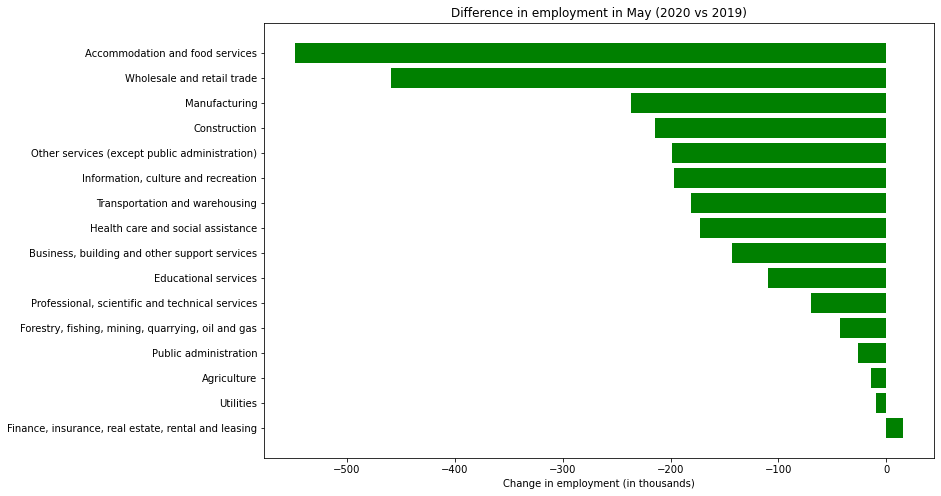

In [68]:
fig, ax = plt.subplots(figsize = (12,8)) 
ax.barh(nov.index, nov['diff'], align='center', color='g')
ax.invert_yaxis()
ax.set_xlabel('Change in employment (in thousands)')
ax.set_title('Difference in employment in May (2020 vs 2019)')
#highlight = 'Total, all industries'
#pos = diff.index.get_loc(highlight)
#ax.patches[pos].set_facecolor('#aa3333')
plt.show()

In general, the paper is able to identify some industries at risk but this approach fail to give the full portrait of the economy.

In [6]:
def query_province(df, province):
    prov2020 = query_month(df, geo=province, month='2020-11')
    prov2019 = query_month(df, geo=province, month='2019-11')
    prov = prov2020.merge(prov2019, on='NAICS')
    prov['diff'] = prov['2020-11'] - prov['2019-11']
    #prov = prov.sort_values('diff', ascending=False)
    prov = prov.set_index('NAICS')
    return prov

In [29]:
qc = query_province(df, 'Quebec')
on = query_province(df, 'Ontario')
al = query_province(df, 'Alberta')

prov = pd.DataFrame({'Quebec': qc['diff'],
                     'Ontario': on['diff'],
                     'Alberta': al['diff']}, 
                     index=qc.index).replace(np.nan, 0)

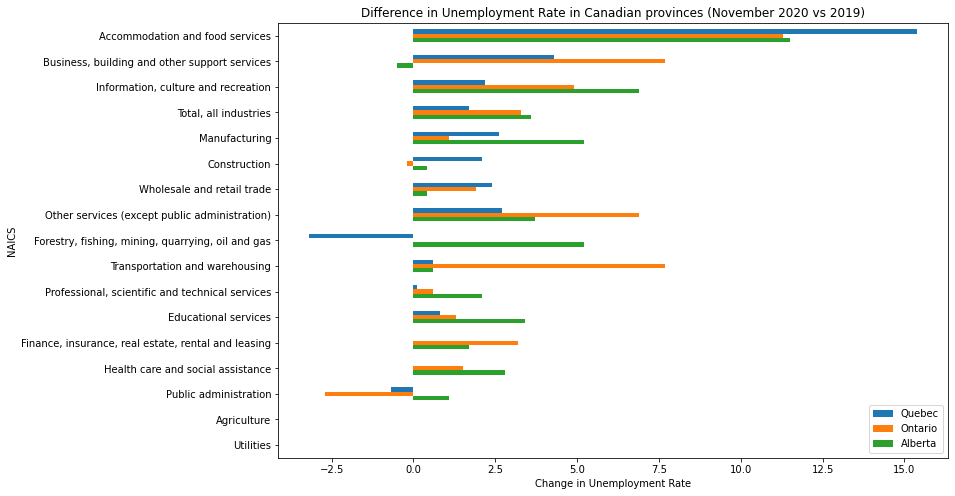

In [30]:
ax = prov.plot.barh(figsize = (12,8))
ax.invert_yaxis()
ax.set_xlabel('Change in Unemployment Rate')
ax.set_title('Difference in Unemployment Rate in Canadian Provinces (November 2020 vs 2019)')
plt.legend(loc='lower right')
plt.show()

In [42]:
males = query_year(df, sex='Males', year='2020')
females = query_year(df, sex='Females', year='2020')